# PostGIS on Greenplum Database
## 1 System preparation
### 1.1 Set system variables, connection string, Greenplum Database auto stats, etc.

In [1]:
import os, re
from IPython.display import display_html

import pygments.lexers
from pygments import highlight
from pygments.formatters import HtmlFormatter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

CONNECTION_STRING = os.getenv('AWSGPDBCONN')

cs = re.match('^postgresql:\/\/(\S+):(\S+)@(\S+):(\S+)\/(\S+)$', CONNECTION_STRING)

DB_USER   = cs.group(1)
DB_PWD    = cs.group(2)
DB_SERVER = cs.group(3)
DB_PORT   = cs.group(4)
DB_NAME   = cs.group(5)

%reload_ext sql
%sql $CONNECTION_STRING

'Connected: gpadmin@gpadmin'

In [2]:
%%sql $DB_USER@$DB_SERVER
SHOW gp_autostats_mode;
ALTER DATABASE gpadmin SET gp_autostats_mode TO 'NONE';
SHOW gp_autostats_mode;

1 rows affected.
Done.
1 rows affected.


gp_autostats_mode
ON_NO_STATS


### 1.2 Prepare AWS System and setup awscli library via pip

In [3]:
shfilecode = !pygmentize -f html -O full,style=friendly -l shell script/1-1-system-prepare.sh
display_html('\n'.join(shfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 #!/bin/bash 

 cd $HOME 

curl -O https://bootstrap.pypa.io/get-pip.py
python $HOME /get-pip.py --force-reinstall
rm $HOME /get-pip.py

mv $HOME /.bash_profile $HOME /.bash_profile.old

cat >> $HOME /.bash_profile << 'EOF' 
 # .bash_profile 

 # Get the aliases and functions 
 if [ -f ~/.bashrc ]; then 
 . ~/.bashrc 
 fi 

 # User specific environment and startup programs 

 export PATH=$HOME/.local/bin:$HOME/bin:$PATH 

 EOF 

chmod 644 $HOME /.bash_profile
 source $HOME /.bash_profile

pip install --upgrade --force-reinstall pip
pip install --upgrade --force-reinstall boto3
pip install --upgrade --force-reinstall awscli

 echo "***********************" 
 echo "* Get AWS CLI version *" 
 echo "***********************" 
aws --version

In [4]:
!ssh-keygen -R $DB_SERVER
!ssh-keyscan $DB_SERVER >> ~/.ssh/known_hosts
!scp -i ~/.ssh/aws-gp.pem script/1-1-system-prepare.sh $DB_USER@$DB_SERVER:system-prepare.sh
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER 'chmod +x ./system-prepare.sh'
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER 'sudo ./system-prepare.sh'

Host ec2-35-178-123-46.eu-west-2.compute.amazonaws.com not found in /root/.ssh/known_hosts
# ec2-35-178-123-46.eu-west-2.compute.amazonaws.com:22 SSH-2.0-OpenSSH_7.4
# ec2-35-178-123-46.eu-west-2.compute.amazonaws.com:22 SSH-2.0-OpenSSH_7.4
# ec2-35-178-123-46.eu-west-2.compute.amazonaws.com:22 SSH-2.0-OpenSSH_7.4
1-1-system-prepare.sh                         100%  712    82.0KB/s   00:00    
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1734k  100 1734k    0     0  12.5M      0 --:--:-- --:--:-- --:--:-- 12.6M
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
  Found existing i

    Uninstalling docutils-0.15.2:
      Successfully uninstalled docutils-0.15.2
  Found existing installation: PyYAML 3.10
ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
***********************
* Get AWS CLI version *
***********************
aws-cli/1.15.30 Python/2.7.5 Linux/3.10.0-957.21.3.el7.x86_64 botocore/1.10.30


### 1.3 Provide AWS Access Key ID & Secret Access Key

In [5]:
shfilecode = !pygmentize -f html -O full,style=friendly -l bash script/1-2-aws-configure.sh
display_html('\n'.join(shfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 #!/bin/bash 

 if [ -d $HOME /.aws ] ; then rm -rf $HOME /.aws ; fi 

mkdir $HOME /.aws

 echo "[default] 
 aws_access_key_id=" $1 " 
 aws_secret_access_key=" $2 "" > $HOME /.aws/credentials

 echo "[default] 
 region=eu-west-2 
 output=json" > $HOME /.aws/config

 #test aws config 
 if [ " $( /usr/local/bin/aws s3 ls s3://amazon-reviews-pds/tsv/ | awk '{print $4}' | awk 'END {print NR}' ) " -eq "0" ] ; 
 then echo "Error on AWS S3 Configuration setup" ; 
 else echo "AWS S3 Configuration setup correctly" ; 
 fi

In [6]:
import getpass

!scp -i ~/.ssh/aws-gp.pem script/1-2-aws-configure.sh $DB_USER@$DB_SERVER:aws-configure.sh
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER 'chmod +x ./aws-configure.sh'

cmd = 'sudo ./aws-configure.sh ' 
cmd = cmd + getpass.getpass("AWS Access Key ID [None]:") 
cmd = cmd + ' ' + getpass.getpass("AWS Secret Access Key [None]:")

!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER $cmd

1-2-aws-configure.sh                          100%  484    66.4KB/s   00:00    
AWS Access Key ID [None]:········
AWS Secret Access Key [None]:········
AWS S3 Configuration setup correctly


### 1.4 Create Greenplum Database Schema and Tables for Demo

In [32]:
sqlfilecode = !pygmentize -f html -O full,style=friendly -l postgres script/8-0-db-maintenance.sql
display_html('\n'.join(sqlfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 DROP SCHEMA IF EXISTS demo CASCADE ; 

 VACUUM FULL VERBOSE ; 

 CREATE SCHEMA demo ;

In [33]:
query = !cat script/8-0-db-maintenance.sql
%sql $DB_USER@$DB_SERVER {''.join(query)}

Done.
Done.
Done.


[]

In [34]:
sqlfilecode = !pygmentize -f html -O full,style=friendly -l postgres script/8-1-create-schema-tables.sql
display_html('\n'.join(sqlfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 CREATE TABLE demo . uber_mov_ldn ( 
 qoy INTEGER , 
 sourceid INTEGER , 
 dstid INTEGER , 
 hod INTEGER , 
 mean_travel_time NUMERIC , 
 standard_deviation_travel_time NUMERIC , 
 geometric_mean_travel_time NUMERIC , 
 geometric_standard_deviation_travel_time NUMERIC 
 ) 
 DISTRIBUTED BY ( sourceid , dstid ) 
 PARTITION BY LIST ( qoy ) 
 SUBPARTITION BY RANGE ( hod ) 
 SUBPARTITION TEMPLATE ( 
 START ( 0 ) END ( 23 ) EVERY ( 1 ), DEFAULT SUBPARTITION OTHERHOD ) 
 ( VALUES ( 201601 , 201602 , 201603 , 201604 , 201701 , 201702 , 201703 , 201704 , 201801 ), DEFAULT PARTITION OTHERQOY ); 

 CREATE TABLE demo . postcode_lookup ( 
 pcd7 TEXT , 
 pcd8 TEXT , 
 pcds TEXT , 
 dointr TEXT , 
 doterm TEXT , 
 usertype TEXT , 
 oa11cd TEXT , 
 lsoa11cd TEXT , 
 msoa11cd TEXT , 
 ladcd TEXT , 
 lsoa11nm TEXT , 
 msoa11nm TEXT , 
 ladnm TEXT , 
 ladnmw TEXT ) 
 DISTRIBUTED RANDOMLY ; 

 CREATE TABLE demo . postcodelatlng ( 
 id INT , 
 postcode VARCHAR ( 8 ), 
 latitude DECIMAL ( 18 , 15 ), 
 longitude DECIMAL ( 18 , 15 )) 
 DISTRIBUTED BY ( id ); 
 
 CREATE TABLE demo . dft_traffic_counts_raw ( 
 count_point_id INTEGER , 
 direction_of_travel CHAR ( 1 ), 
 YEAR SMALLINT , 
 count_date TEXT , 
 HOUR SMALLINT , 
 region_id INTEGER , 
 region_name TEXT , 
 region_ons_code TEXT , 
 local_authority_id INTEGER , 
 local_authority_name TEXT , 
 local_authoirty_ons_code TEXT , 
 road_name TEXT , 
 road_category VARCHAR ( 3 ), 
 road_type TEXT , 
 start_junction_road_name TEXT , 
 end_junction_road_name TEXT , 
 easting BIGINT , 
 northing BIGINT , 
 latitude NUMERIC ( 18 , 15 ), 
 longitude NUMERIC ( 18 , 15 ), 
 link_length_km NUMERIC , 
 link_length_miles NUMERIC , 
 pedal_cycles INTEGER , 
 two_wheeled_motor_vehicles INTEGER , 
 cars_and_taxis INTEGER , 
 buses_and_coaches INTEGER , 
 lgvs INTEGER , 
 hgvs_2_rigid_axle INTEGER , 
 hgvs_3_rigid_axle INTEGER , 
 hgvs_4_or_more_rigid_axle INTEGER , 
 hgvs_3_or_4_articulated_axle INTEGER , 
 hgvs_5_articulated_axle INTEGER , 
 hgvs_6_articulated_axle INTEGER , 
 all_hgvs INTEGER , 
 all_motor_vehicles INTEGER ) 
 DISTRIBUTED BY ( count_point_id ); 
 
 CREATE TABLE demo . london_lsoa ( 
 dat_type text NULL , 
 geometry geometry NULL , 
 msoa_code text NULL , 
 msoa_name text NULL , 
 la_code text NULL , 
 la_name text NULL , 
 geoeast int4 NULL , 
 geonorth int4 NULL , 
 popeast int4 NULL , 
 popnorth int4 NULL , 
 area_km2 numeric NULL , 
 movement_id int4 NULL , 
 display_name text NULL 
 ) 
 DISTRIBUTED BY ( movement_id ); 
 
 CREATE TABLE demo . london_lsoa_txt ( 
 input TEXT ) 
 DISTRIBUTED RANDOMLY ;

In [35]:
query = !cat script/8-1-create-schema-tables.sql
%sql $DB_USER@$DB_SERVER {''.join(query)}

Done.
Done.
Done.
Done.
Done.
Done.


[]

### 1.5 Copy source files from AWS S3

In [36]:
shfilecode = !pygmentize -f html -O full,style=friendly -l bash script/8-3-copy-data-from-s3.sh
display_html('\n'.join(shfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 #!/bin/bash 

 export S3_DATA_DIR = /var/tmp_s3_data

 if [ -d $S3_DATA_DIR ] ; then rm -rf $S3_DATA_DIR ; fi 

mkdir $S3_DATA_DIR 
sudo chown gpadmin $S3_DATA_DIR 
 cd $S3_DATA_DIR 

ls -laF $S3_DATA_DIR 

/usr/local/bin/aws s3 cp s3://uber-movement-ldn/PCD_OA_LSOA_MSOA_LAD_AUG19_UK_LU.csv PCD_OA_LSOA_MSOA_LAD_AUG19_UK_LU.csv
/usr/local/bin/aws s3 cp s3://uber-movement-ldn/uber-movement-ldn.tar.gz uber-movement-ldn.tar.gz
/usr/local/bin/aws s3 cp s3://uber-movement-ldn/ukpostcodes.csv ukpostcodes.csv
/usr/local/bin/aws s3 cp s3://uber-movement-ldn/2018-MRDB-minimal.shp 2018 -MRDB-minimal.shp
/usr/local/bin/aws s3 cp s3://uber-movement-ldn/2018-MRDB-minimal.shx 2018 -MRDB-minimal.shx
/usr/local/bin/aws s3 cp s3://uber-movement-ldn/2018-MRDB-minimal.dbf 2018 -MRDB-minimal.dbf
/usr/local/bin/aws s3 cp s3://uber-movement-ldn/dft_traffic_counts_raw_counts.tar.gz dft_traffic_counts_raw_counts.tar.gz

In [37]:
!scp -i ~/.ssh/aws-gp.pem script/8-3-copy-data-from-s3.sh $DB_USER@$DB_SERVER:copy-data-from-s3.sh
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER 'chmod +x ./copy-data-from-s3.sh'
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER "sudo ./copy-data-from-s3.sh"

8-3-copy-data-from-s3.sh                      100%  892   128.2KB/s   00:00    
total 4
drwxr-xr-x   2 gpadmin root    6 Oct 25 09:36 ./
drwxr-xr-x. 21 root    root 4096 Oct 25 09:36 ../
download: s3://uber-movement-ldn/PCD_OA_LSOA_MSOA_LAD_AUG19_UK_LU.csv to ./PCD_OA_LSOA_MSOA_LAD_AUG19_UK_LU.csv
download: s3://uber-movement-ldn/uber-movement-ldn.tar.gz to ./uber-movement-ldn.tar.gz
download: s3://uber-movement-ldn/ukpostcodes.csv to ./ukpostcodes.csv
download: s3://uber-movement-ldn/2018-MRDB-minimal.shp to ./2018-MRDB-minimal.shp
download: s3://uber-movement-ldn/2018-MRDB-minimal.shx to ./2018-MRDB-minimal.shx
download: s3://uber-movement-ldn/2018-MRDB-minimal.dbf to ./2018-MRDB-minimal.dbf
download: s3://uber-movement-ldn/dft_traffic_counts_raw_counts.tar.gz to ./dft_traffic_counts_raw_counts.tar.gz


### 1.6 Load data
- **Load Uber Movement (London) data from `uber-movement-ldn.tar.gz` file into `demo.uber_mov_ldn` table using GPLoad**

In [38]:
sqlfilecode = !pygmentize -f html -O full,style=friendly -l yaml script/8-4-load-uber-movement-ldn.yaml
display_html('\n'.join(sqlfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 --- 
 VERSION : 1.0.0.1 
 GPLOAD : 
 INPUT : 
 - SOURCE : 
 FILE : 
 - /var/tmp_s3_data/uber-movement-ldn.tar.gz 
 - FORMAT : csv 
 - HEADER : true 
 - LOG_ERRORS : true 
 - MAX_LINE_LENGTH : 1000000 
 - ERROR_LIMIT : 50000 
 OUTPUT : 
 - TABLE : demo.uber_mov_ldn 
 - MODE : insert 
 PRELOAD : 
 - TRUNCATE : true 
 - REUSE_TABLES : true

In [39]:
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER 'if [ -f ./load-uber-movement-ldn.yaml ]; then rm ./load-uber-movement-ldn.yaml; fi'
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER 'if [ -f ./load-uber-movement-ldn.log ]; then rm ./load-uber-movement-ldn.log; fi'

!scp -i ~/.ssh/aws-gp.pem script/8-4-load-uber-movement-ldn.yaml $DB_USER@$DB_SERVER:load-uber-movement-ldn.yaml
cmd = "gpload -d {0} -f ./load-uber-movement-ldn.yaml -l ./load-uber-movement-ldn.log 2>&1".format(DB_USER) 
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER $cmd

8-4-load-uber-movement-ldn.yaml               100%  357    52.4KB/s   00:00    
2019-10-25 09:36:41|INFO|gpload session started 2019-10-25 09:36:41
2019-10-25 09:36:41|INFO|no host supplied, defaulting to localhost
2019-10-25 09:36:41|INFO|started gpfdist -p 8000 -P 9000 -f "/var/tmp_s3_data/uber-movement-ldn.tar.gz" -t 30 -m 1000000
2019-10-25 09:36:46|INFO|did not find an external table to reuse. creating ext_gpload_reusable_918e3642_f702_11e9_b376_06a90659ec6c
2019-10-25 09:37:49|WARN|24 bad rows
2019-10-25 09:37:49|WARN|Please use following query to access the detailed error
2019-10-25 09:37:49|WARN|select * from gp_read_error_log('ext_gpload_reusable_918e3642_f702_11e9_b376_06a90659ec6c') where cmdtime > to_timestamp('1571992601.55')
2019-10-25 09:37:49|INFO|running time: 67.94 seconds
2019-10-25 09:37:49|INFO|rows Inserted          = 68939823
2019-10-25 09:37:49|INFO|rows Updated           = 0
2019-10-25 09:37:49|INFO|data formatting errors = 24
2019-10-25 09:37:49|INFO|gpload su

- **Load UK Postcodes/Lower-/Middle Layer Super Output Area Information from `PCD_OA_LSOA_MSOA_LAD_AUG19_UK_LU.csv` file into `demo.postcode_lookup` table using GPLoad**

In [40]:
sqlfilecode = !pygmentize -f html -O full,style=friendly -l yaml script/8-4-load-postcodes.yaml
display_html('\n'.join(sqlfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 --- 
 VERSION : 1.0.0.1 
 GPLOAD : 
 INPUT : 
 - SOURCE : 
 FILE : 
 - /var/tmp_s3_data/PCD_OA_LSOA_MSOA_LAD_AUG19_UK_LU.csv 
 - FORMAT : csv 
 - HEADER : true 
 - LOG_ERRORS : true 
 - MAX_LINE_LENGTH : 1000000 
 - ERROR_LIMIT : 50000 
 OUTPUT : 
 - TABLE : demo.postcode_lookup 
 - MODE : insert 
 PRELOAD : 
 - TRUNCATE : true 
 - REUSE_TABLES : true 
 SQL : 
 - AFTER : "ALTER TABLE demo.postcode_lookup ALTER COLUMN dointr TYPE INTEGER USING COALESCE(NULLIF(dointr, ''), '0')::INT; ALTER TABLE demo.postcode_lookup ALTER COLUMN doterm TYPE INTEGER USING COALESCE(NULLIF(doterm, ''), '0')::INT; ALTER TABLE demo.postcode_lookup ALTER COLUMN usertype TYPE SMALLINT USING COALESCE(NULLIF(usertype, ''), '0')::SMALLINT;"

In [41]:
!scp -i ~/.ssh/aws-gp.pem script/8-4-load-postcodes.yaml $DB_USER@$DB_SERVER:load-postcodes.yaml
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER 'if [ -f ./load-postcodes.log ]; then rm ./load-postcodes.log; fi'

cmd = "gpload -d {0} -f ./load-postcodes.yaml -l ./load-postcodes.log 2>&1".format(DB_USER) 
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER $cmd

8-4-load-postcodes.yaml                       100%  742    81.6KB/s   00:00    
2019-10-25 09:37:51|INFO|gpload session started 2019-10-25 09:37:51
2019-10-25 09:37:51|INFO|no host supplied, defaulting to localhost
2019-10-25 09:37:51|INFO|started gpfdist -p 8000 -P 9000 -f "/var/tmp_s3_data/PCD_OA_LSOA_MSOA_LAD_AUG19_UK_LU.csv" -t 30 -m 1000000
2019-10-25 09:37:51|INFO|did not find an external table to reuse. creating ext_gpload_reusable_bafde0cc_f702_11e9_85c5_06a90659ec6c
2019-10-25 09:38:11|INFO|running time: 20.10 seconds
2019-10-25 09:38:11|INFO|rows Inserted          = 2632804
2019-10-25 09:38:11|INFO|rows Updated           = 0
2019-10-25 09:38:11|INFO|data formatting errors = 0
2019-10-25 09:38:11|INFO|gpload succeeded


- **Load UK Postcodes Geogaphical Information `ukpostcodes.csv` file into `demo.postcodelatlng` table using GPLoad**

In [42]:
sqlfilecode = !pygmentize -f html -O full,style=friendly -l yaml script/8-4-load-postcodes-coord.yaml
display_html('\n'.join(sqlfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 --- 
 VERSION : 1.0.0.1 
 GPLOAD : 
 INPUT : 
 - SOURCE : 
 FILE : 
 - /var/tmp_s3_data/ukpostcodes.csv 
 - FORMAT : csv 
 - HEADER : true 
 - LOG_ERRORS : true 
 - MAX_LINE_LENGTH : 1000000 
 - ERROR_LIMIT : 50000 
 OUTPUT : 
 - TABLE : demo.postcodelatlng 
 - MODE : insert 
 PRELOAD : 
 - TRUNCATE : true 
 - REUSE_TABLES : true

In [43]:
!scp -i ~/.ssh/aws-gp.pem script/8-4-load-postcodes-coord.yaml $DB_USER@$DB_SERVER:load-postcodes-coord.yaml
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER 'if [ -f ./load-postcodes-coord.log ]; then rm ./load-postcodes-coord.log; fi'

cmd = "gpload -d {0} -f ./load-postcodes-coord.yaml -l ./load-postcodes-coord.log 2>&1".format(DB_USER) 
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER $cmd

8-4-load-postcodes-coord.yaml                 100%  351    27.1KB/s   00:00    
2019-10-25 09:38:12|INFO|gpload session started 2019-10-25 09:38:12
2019-10-25 09:38:12|INFO|no host supplied, defaulting to localhost
2019-10-25 09:38:12|INFO|started gpfdist -p 8000 -P 9000 -f "/var/tmp_s3_data/ukpostcodes.csv" -t 30 -m 1000000
2019-10-25 09:38:12|INFO|did not find an external table to reuse. creating ext_gpload_reusable_c7f5a882_f702_11e9_87d0_06a90659ec6c
2019-10-25 09:38:13|INFO|running time: 0.69 seconds
2019-10-25 09:38:13|INFO|rows Inserted          = 1762397
2019-10-25 09:38:13|INFO|rows Updated           = 0
2019-10-25 09:38:13|INFO|data formatting errors = 0
2019-10-25 09:38:13|INFO|gpload succeeded


- **Load Lower Layer Super Output Area information from `london-lsoa.json` file into `demo.london_LSOA` table**

In [44]:
sqlfilecode = !pygmentize -f html -O full,style=friendly -l postgres script/8-4-load-london-lsoa-txt.sql
display_html('\n'.join(sqlfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 DELETE FROM demo . london_LSOA_TXT ; 
 INSERT INTO demo . london_LSOA_TXT ( input ) VALUES ( '{0}' );

In [45]:
import boto3
import json

s3 = boto3.resource('s3')

content_object = s3.Object('uber-movement-ldn', 'london-lsoa.json')
file_content = content_object.get()['Body'].read().decode('utf-8')
json_content = json.loads(file_content)

data = json.dumps(json_content)

lnd_lsoa_txt_cmd = !cat script/8-4-load-london-lsoa-txt.sql
lnd_lsoa_txt_cmd = ''.join(lnd_lsoa_txt_cmd).format(str(data))

%sql $DB_USER@$DB_SERVER {lnd_lsoa_txt_cmd}

0 rows affected.
1 rows affected.


[]

In [46]:
sqlfilecode = !pygmentize -f html -O full,style=friendly -l postgres script/8-4-load-london-lsoa.sql
display_html('\n'.join(sqlfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 INSERT INTO demo . london_LSOA 
 SELECT 
 dat_features ->> 'type' AS dat_type , 
 ST_GeomFromGeoJSON ( dat_features ->> 'geometry' ) AS geometry , 
 (( dat_features ->> 'properties' ) :: json ) ->> 'msoa_code' AS msoa_code , 
 (( dat_features ->> 'properties' ) :: json ) ->> 'msoa_name' AS msoa_name , 
 (( dat_features ->> 'properties' ) :: json ) ->> 'la_code' AS la_code , 
 (( dat_features ->> 'properties' ) :: json ) ->> 'la_name' AS la_name , 
 ((( dat_features ->> 'properties' ) :: json ) ->> 'geoeast' ) :: INT AS geoeast , 
 ((( dat_features ->> 'properties' ) :: json ) ->> 'geonorth' ) :: INT AS geonorth , 
 ((( dat_features ->> 'properties' ) :: json ) ->> 'popeast' ) :: INT AS popeast , 
 ((( dat_features ->> 'properties' ) :: json ) ->> 'popnorth' ) :: INT AS popnorth , 
 ((( dat_features ->> 'properties' ) :: json ) ->> 'area_km2' ) :: NUMERIC AS area_km2 , 
 ((( dat_features ->> 'properties' ) :: json ) ->> 'MOVEMENT_ID' ) :: INT AS movement_id , 
 (( dat_features ->> 'properties' ) :: json ) ->> 'DISPLAY_NAME' AS display_name 
 FROM ( 
 SELECT JSON_ARRAY_ELEMENTS ( dat -> 'features' ) :: json AS dat_features 
 FROM ( 
 SELECT input :: JSON AS dat 
 FROM demo . london_LSOA_TXT 
 ) A 
 ) foo ; 

 SELECT COUNT ( * ) FROM demo . london_lsoa ;

In [47]:
lnd_lsoa_cmd = !cat script/8-4-load-london-lsoa.sql

%sql $DB_USER@$DB_SERVER {''.join(lnd_lsoa_cmd)}

983 rows affected.
1 rows affected.


count
983


- **Load Shape file of the major road network Information from `2018-MRDB-minimal.shp` file into `demo.major_roads_network` table using SHP2PGSQL and psql utilities**

In [48]:
shp2pgsqlcode = !pygmentize -f html -O full,style=friendly -l shell script/8-5-major-road-network-shp2pgsql.sh
display_html('\n'.join(shp2pgsqlcode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 /usr/local/greenplum-db/bin/shp2pgsql -d -D -i /var/tmp_s3_data/2018-MRDB-minimal.shp demo.major_roads_network > /var/tmp_s3_data/2018-MRDB-minimal.sql

In [49]:
shp2pgsqlcmd = !cat script/8-5-major-road-network-shp2pgsql.sh
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER "{''.join(shp2pgsqlcmd)}"

Shapefile type: Arc
Postgis type: MULTILINESTRING[2]


In [50]:
psqlfilecode = !pygmentize -f html -O full,style=friendly -l postgres script/8-5-major-road-network-psql.sh
display_html('\n'.join(psqlfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 psql - d { 0 } - f '/var/tmp_s3_data/2018-MRDB-minimal.sql'

In [51]:
psql_cmd = !cat script/8-5-major-road-network-psql.sh
psql_cmd = ''.join(psql_cmd).format(DB_USER)
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER "{psql_cmd}"

SET
SET
BEGIN
psql:/var/tmp_s3_data/2018-MRDB-minimal.sql:3: ERROR:  column not found in geometry_columns table
CONTEXT:  SQL statement "SELECT DropGeometryColumn('', $1 , $2 , $3 )"
PL/pgSQL function "dropgeometrycolumn" line 4 at SQL statement
psql:/var/tmp_s3_data/2018-MRDB-minimal.sql:4: ERROR:  table "major_roads_network" does not exist
psql:/var/tmp_s3_data/2018-MRDB-minimal.sql:8: NOTICE:  CREATE TABLE will create implicit sequence "major_roads_network_gid_seq" for serial column "major_roads_network.gid"
psql:/var/tmp_s3_data/2018-MRDB-minimal.sql:8: NOTICE:  Table doesn't have 'DISTRIBUTED BY' clause -- Using column named 'gid' as the Greenplum Database data distribution key for this table.
HINT:  The 'DISTRIBUTED BY' clause determines the distribution of data. Make sure column(s) chosen are the optimal data distribution key to minimize skew.
CREATE TABLE
psql:/var/tmp_s3_data/2018-MRDB-minimal.sql:9: NOTICE:  ALTER TABLE / ADD PRIMARY KEY will create implicit index "major_road

In [52]:
sqlfilecode = !pygmentize -f html -O full,style=friendly -l postgres script/8-5-major-road-network-check.sql
display_html('\n'.join(sqlfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 SELECT COUNT ( * ) FROM demo . major_roads_network ;

In [53]:
query = !cat script/8-5-major-road-network-check.sql
%sql $DB_USER@$DB_SERVER {''.join(query)}

1 rows affected.


count
18193


- **Load Vehicle counts recorded on major and minor roads (2000 - 2018) from `dft_traffic_counts_raw_counts.zip` file into `demo.dft_traffic_counts_raw` table using GPLoad**

In [54]:
sqlfilecode = !pygmentize -f html -O full,style=friendly -l yaml script/8-6-load-raw-traffic-counts.yaml
display_html('\n'.join(sqlfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 --- 
 VERSION : 1.0.0.1 
 GPLOAD : 
 INPUT : 
 - SOURCE : 
 FILE : 
 - /var/tmp_s3_data/dft_traffic_counts_raw_counts.tar.gz 
 - FORMAT : csv 
 - HEADER : true 
 - NULL_AS : 'NULL' 
 - LOG_ERRORS : true 
 - MAX_LINE_LENGTH : 1000000 
 - ERROR_LIMIT : 50000 
 OUTPUT : 
 - TABLE : demo.dft_traffic_counts_raw 
 - MODE : insert 
 PRELOAD : 
 - TRUNCATE : true 
 - REUSE_TABLES : true

In [55]:
!scp -i ~/.ssh/aws-gp.pem script/8-6-load-raw-traffic-counts.yaml $DB_USER@$DB_SERVER:load-raw-traffic-counts.yaml
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER 'if [ -f ./load-raw-traffic-counts.log ]; then rm ./load-raw-traffic-counts.log; fi'

cmd = "gpload -d {0} -f ./load-raw-traffic-counts.yaml -l ./load-raw-traffic-counts.log 2>&1".format(DB_USER) 
!ssh -i ~/.ssh/aws-gp.pem $DB_USER@$DB_SERVER $cmd

8-6-load-raw-traffic-counts.yaml              100%  401    52.3KB/s   00:00    
2019-10-25 09:38:23|INFO|gpload session started 2019-10-25 09:38:23
2019-10-25 09:38:23|INFO|no host supplied, defaulting to localhost
2019-10-25 09:38:23|INFO|started gpfdist -p 8000 -P 9000 -f "/var/tmp_s3_data/dft_traffic_counts_raw_counts.tar.gz" -t 30 -m 1000000
2019-10-25 09:38:23|INFO|did not find an external table to reuse. creating ext_gpload_reusable_ce34dc90_f702_11e9_ac18_06a90659ec6c
2019-10-25 09:38:26|WARN|1 bad row
2019-10-25 09:38:26|WARN|Please use following query to access the detailed error
2019-10-25 09:38:26|WARN|select * from gp_read_error_log('ext_gpload_reusable_ce34dc90_f702_11e9_ac18_06a90659ec6c') where cmdtime > to_timestamp('1571992703.31')
2019-10-25 09:38:26|INFO|running time: 3.38 seconds
2019-10-25 09:38:26|INFO|rows Inserted          = 3919788
2019-10-25 09:38:26|INFO|rows Updated           = 0
2019-10-25 09:38:26|INFO|data formatting errors = 1
2019-10-25 09:38:26|INFO|gp

### 1.7 Collect statictics over the imported datasets

In [159]:
sqlfilecode = !pygmentize -f html -O full,style=friendly -l postgres script/8-7-collect-table-statistics.sql
display_html('\n'.join(sqlfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 ANALYZE demo . uber_mov_ldn ( qoy , hod , sourceid , dstid ); 
 ANALYZE demo . london_lsoa ( movement_id );

In [160]:
query = !cat script/8-7-collect-table-statistics.sql
%sql $DB_USER@$DB_SERVER {''.join(query)}

Done.
Done.


[]

### 1.8 Prepare data structures

In [161]:
sqlfilecode = !pygmentize -f html -O full,style=friendly -l postgres script/8-8-postgis-support-data-structures.sql
display_html('\n'.join(sqlfilecode), raw=True)

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN"
 "http://www.w3.org/TR/html4/strict.dtd">
<!--
generated by Pygments 
Copyright 2006-2019 by the Pygments team.
Licensed under the BSD license, see LICENSE for details.
-->
 
 
 
 
 
 
 
 

 DROP VIEW IF EXISTS demo . travel_speed ; 
 
 CREATE VIEW demo . travel_speed AS 
 SELECT 
 qoy , 
 hod , 
 sourceid , 
 dstid , 
 uml . mean_travel_time , 
 ROUND ((( 10 * ST_Distance ( ST_Centroid ( ll1 . geometry ), ST_Centroid ( ll2 . geometry )) * 111257 ) / ( 36 * uml . mean_travel_time )) :: NUMERIC , 5 ) AS ST_Kmph , 
 ROUND (( 10 * ST_Distance ( ST_Centroid ( ll1 . geometry ), ST_Centroid ( ll2 . geometry )) * 111257 ) :: NUMERIC , 5 ) AS ST_DistanceKm 
 FROM demo . uber_mov_ldn AS uml 
 INNER JOIN demo . london_lsoa AS ll1 
 ON uml . sourceid = ll1 . movement_id 
 INNER JOIN demo . london_lsoa AS ll2 
 ON uml . dstid = ll2 . movement_id ; 
 
 DROP TABLE IF EXISTS demo . ldn_max_kmph_per_ts_src_dst ; 
 
 CREATE TABLE demo . ldn_max_kmph_per_ts_src_dst AS 
 SELECT A . * 
 FROM ( 
 SELECT qoy , hod , sourceid , dstid , MAX ( ST_Kmph ) AS max_kmph 
 FROM demo . travel_speed 
 GROUP BY qoy , hod , sourceid , dstid ) A , ( 
 SELECT qoy , hod , MAX ( ST_Kmph ) AS max_kmph 
 FROM demo . travel_speed 
 GROUP BY qoy , hod ) B 
 WHERE 
 A . qoy = B . qoy 
 AND A . hod = B . hod 
 AND A . max_kmph = B . max_kmph 
 DISTRIBUTED BY ( sourceid , dstid ); 
 
 DROP TABLE IF EXISTS demo . ldn_max_distancekm_per_ts_src_dst ; 
 
 CREATE TABLE demo . ldn_max_distancekm_per_ts_src_dst AS 
 SELECT A . * 
 FROM ( 
 SELECT qoy , hod , sourceid , dstid , MAX ( ST_DistanceKm ) AS max_distancekm 
 FROM demo . travel_speed 
 GROUP BY qoy , hod , sourceid , dstid ) A , ( 
 SELECT qoy , hod , MAX ( ST_DistanceKm ) AS max_distancekm 
 FROM demo . travel_speed 
 GROUP BY qoy , hod ) B 
 WHERE 
 A . qoy = B . qoy 
 AND A . hod = B . hod 
 AND A . max_distancekm = B . max_distancekm 
 DISTRIBUTED BY ( sourceid , dstid ); 
 
 DROP TABLE IF EXISTS demo . ldn_min_kmph_per_ts_src_dst ; 
 
 CREATE TABLE demo . ldn_min_kmph_per_ts_src_dst AS 
 SELECT A . * 
 FROM ( 
 SELECT qoy , hod , sourceid , dstid , MIN ( ST_Kmph ) AS min_kmph 
 FROM demo . travel_speed 
 GROUP BY qoy , hod , sourceid , dstid ) A , ( 
 SELECT qoy , hod , MIN ( ST_Kmph ) AS min_kmph 
 FROM demo . travel_speed 
 GROUP BY qoy , hod ) B 
 WHERE 
 A . qoy = B . qoy 
 AND A . hod = B . hod 
 AND A . min_kmph = B . min_kmph 
 DISTRIBUTED BY ( sourceid , dstid ); 
 
 DROP TABLE IF EXISTS demo . ldn_min_distancekm_per_ts_src_dst ; 
 
 CREATE TABLE demo . ldn_min_distancekm_per_ts_src_dst AS 
 SELECT A . * 
 FROM ( 
 SELECT qoy , hod , sourceid , dstid , MIN ( ST_DistanceKm ) AS min_distancekm 
 FROM demo . travel_speed 
 GROUP BY qoy , hod , sourceid , dstid ) A , ( 
 SELECT qoy , hod , MIN ( ST_DistanceKm ) AS min_distancekm 
 FROM demo . travel_speed 
 GROUP BY qoy , hod ) B 
 WHERE 
 A . qoy = B . qoy 
 AND A . hod = B . hod 
 AND A . min_distancekm = B . min_distancekm 
 DISTRIBUTED BY ( sourceid , dstid );

In [162]:
query = !cat script/8-8-postgis-support-data-structures.sql
%sql $DB_USER@$DB_SERVER {''.join(query)}

Done.
Done.
Done.
216 rows affected.
Done.
263 rows affected.
Done.
8319 rows affected.
Done.
8517 rows affected.


[]

## 2 PostGIS

In [155]:

 
# Make a data frame
result = %sql $DB_USER@$DB_SERVER SELECT * FROM demo.ldn_pivot_1 ORDER BY 1
df = result.DataFrame()

24 rows affected.


,hod,max_kmph_avg_qoy_201601,max_kmph_avg_qoy_201602,max_kmph_avg_qoy_201603,max_kmph_avg_qoy_201604,max_kmph_avg_qoy_201701,max_kmph_avg_qoy_201702,max_kmph_avg_qoy_201703,max_kmph_avg_qoy_201704,max_kmph_avg_qoy_201801
0,0,18.8942200000000000,18.8006700000000000,20.7449300000000000,20.6964700000000000,20.9865300000000000,20.8466200000000000,21.0488600000000000,21.4264000000000000,21.6180900000000000
1,1,21.5611000000000000,22.3874000000000000,23.3716800000000000,23.7316500000000000,23.3460200000000000,21.7998300000000000,22.4963600000000000,22.4157200000000000,22.8100800000000000
2,2,22.4536000000000000,22.6111800000000000,24.3457200000000000,23.0574200000000000,21.3919100000000000,22.1080800000000000,22.9727300000000000,22.6497200000000000,21.7063600000000000
3,3,20.3556900000000000,21.2338300000000000,23.3306500000000000,20.6602700000000000,20.1550300000000000,22.0988900000000000,20.4221600000000000,21.2465600000000000,20.9575700000000000
4,4,20.8425400000000000,20.6442300000000000,22.1541500000000000,20.0221800000000000,19.9246200000000000,20.5723200000000000,20.0902800000000000,21.4436800000000000,19.3445700000000000
5,5,20.8777800000000000,21.8420100000000000,23.9757000000000000,20.4778400000000000,20.7154800000000000,21.8222000000000000,20.7733000000000000,20.6984900000000000,20.9534400000000000
6,6,18.7278100000000000,20.0297200000000000,18.6228400000000000,18.8406500000000000,18.8039900000000000,21.1872800000000000,18.8607000000000000,19.3094400000000000,19.1184600000000000
7,7,15.5648400000000000,16.2441200000000000,15.7737600000000000,15.6741500000000000,15.3971600000000000,15.4964200000000000,16.0455400000000000,15.2969400000000000,15.1914800000000000
8,8,15.4376100000000000,14.8014300000000000,15.1046900000000000,15.4083700000000000,15.0616700000000000,14.5759500000000000,15.1241300000000000,14.3895300000000000,14.9678800000000000
9,9,17.0636900000000000,15.1533800000000000,15.6107800000000000,15.3882000000000000,15.7761100000000000,15.1068500000000000,15.5191600000000000,15.4896100000000000,15.5305500000000000


## Scratchpad

In [156]:
import datetime as dt
hours = [dt.time(i).strftime('%I %p') for i in range(24)]
hours

['12 AM',
 '01 AM',
 '02 AM',
 '03 AM',
 '04 AM',
 '05 AM',
 '06 AM',
 '07 AM',
 '08 AM',
 '09 AM',
 '10 AM',
 '11 AM',
 '12 PM',
 '01 PM',
 '02 PM',
 '03 PM',
 '04 PM',
 '05 PM',
 '06 PM',
 '07 PM',
 '08 PM',
 '09 PM',
 '10 PM',
 '11 PM']

Text(0, 0.5, 'Speed(km/h)')

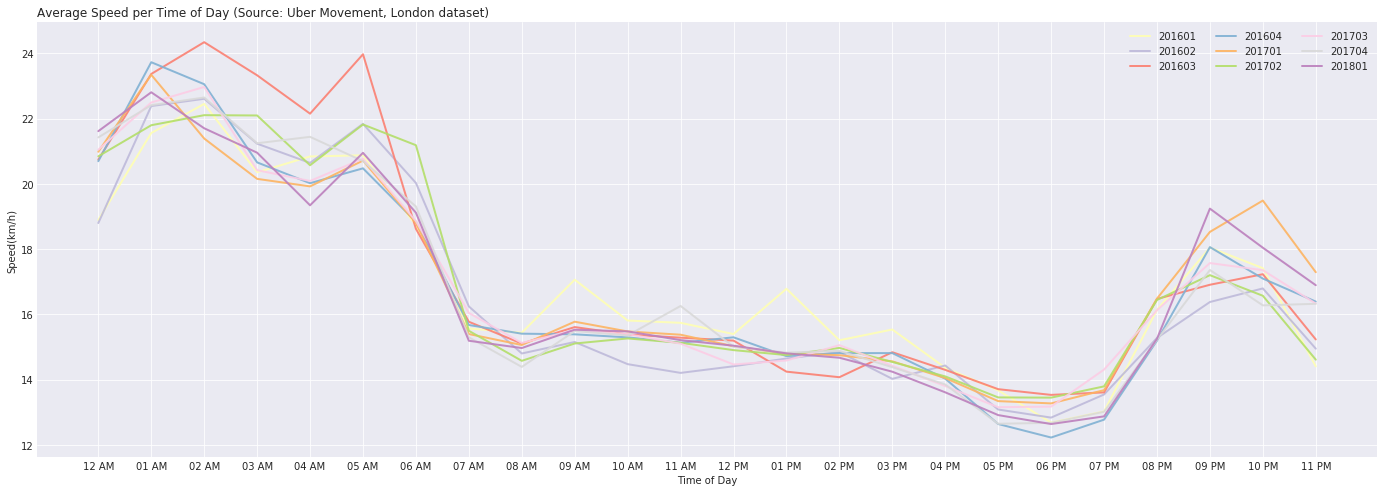

In [157]:
#### style
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(24,8))

plt.xticks(np.arange(24, step=1), hours[0:25])
 
# create a color palette
palette = plt.get_cmap('Set3')
 
# multiple line plot
num=0
for column in df.drop('hod', axis=1):
    num+=1
    plt.plot(df['hod'], df[column], marker='', color=palette(num), linewidth=2, alpha=0.9, label=column[-6:])
 
# Add legend
plt.legend(loc='best', ncol=3)
 
# Add titles
plt.title("Average Speed per Time of Day (Source: Uber Movement, London dataset)", 
          loc='left', fontsize=12, fontweight=2)
plt.xlabel("Time of Day")
plt.ylabel("Speed(km/h)")

